In [2]:
import scipy.signal as signal
import numpy as np
import matplotlib.pyplot as plt
import wfdb

In [17]:
def haar_filter(x,fs):
    #constants
    B1 = int(0.025*fs)
    B2 = int(0.06*fs)
    c = 2 * (B2 - B1)/(2*B1 +1)
    #signals
    y1 = np.zeros(len(x))
    y2= np.zeros(len(x))
    y = np.zeros(len(x))
    tmp= np.zeros(B2)
    x_padded = np.concatenate((tmp,x,tmp))
    #go through samples
    h = np.zeros(2*(B1+B2))
    tmp = np.zeros(2*(B1+B2))
    tmp[:B2] = c
    tmp[B2:B1+B2] = -1
    h = np.concatenate((tmp[::-1],tmp))

    #return signal.convolve(x,h,mode='same')

    for i in range(len(y)):
        #plus B2 in x[] is because of padding
        y1[i] = (c+1)*(x_padded[i+B1 + B2] - x_padded[i-B1 +B2]) + y1[i-1]
        y2[i] = -(x_padded[i+B2 + B2] - x_padded[i-B2 + B2] + y2[i-1])
        y[i] = y1[i] + y2[i]
        #y[i] = -sum(x_padded[i-B1+B2:i+B1+B2+1]) + (c+1) * sum(x_padded[i-B2+B2:i+B2+B2+1])
    return y

In [4]:
def get_candidates(y,x_no_baseline, fs, c1 = 0.55):
    x2 = np.zeros(len(x_no_baseline))
    #fill x2 by the formula from paper
    x2[1:len(x_no_baseline)-1] = np.array( [2 * x_no_baseline[n] - x_no_baseline[n+1] - x_no_baseline[n-1] for n in range(1, len(x_no_baseline)-1)] )
    #calculate s
    s = np.array([y[n]*(x_no_baseline[n] + c1*x2[n]) for n in range(len(y))])
    #tmp just to find the correct range of checking
    tmp = int(0.2*fs)
    #find candidates
    candidates =[]
    for k in range(tmp, len(s)-tmp):
        for n in range(-tmp, tmp):
            if np.abs(s[k]) < np.abs(s[k+n]):
                break
            elif n == tmp-1:
                candidates.append(k)

    return candidates, s

In [5]:
#še popravki - skippam če jih ni 5 še prepoznanih (za W1 in W2) - da se bolš nrdit


def detect_beats(s,x_no_baseline,candidates, fs, T=0.1, beta1=0.5, beta2=0.5, taus=[0.08,  0.12, 0.2, 0.25, 0.35], omega_treshold = 0.1):
    
    #current s in the window
    s_current = []
    #window size
    seconds_window = 10
    samples_window = fs*seconds_window

    #recent detected number
    recent_detected_num = 5

    #detected beats
    detected = []

    #for every candidate
    for i in candidates:
        s_current = []
        for j in range(i-samples_window, i):
            #skip if out of range
            if j < 0:
                continue
            s_current.append(abs(s[j]))

        #calculate W1
        W1 = T
        if len(s_current) > 5:
            W1 = sorted(s_current)[-5] +T
            

        #calculate W2
        W2 = beta1
        det_len = len(detected)
        #only if there is at least 5 detected beats
        if det_len > 5:
            recent_det = detected[det_len - recent_detected_num: det_len]

            mew = np.mean([recent_det[i] - recent_det[i+1] for i in range(3)])


            
            if recent_det[-2] - recent_det[-3] < 0.7*mew and det_len > 6:
              
                tmp = recent_det

                recent_det = [detected[-6]]
                recent_det.extend(tmp[:-1])

            recent_det.append(i)
                

            Ie = sum([taus[i] * (recent_det[i] - recent_det[i+1]) for i in range(5)])

            
            W2 = beta1 + beta2 * abs((i - recent_det[0])/Ie - round((i - recent_det[0])/Ie))
            
        treshold = W1*W2


        omega = 1/2
        if i - int(0.1*fs) > 0:
            tmp_list=  [x_no_baseline[j] for j in range(i - int(0.1*fs), i + int(0.1*fs))]
            u1 = max(tmp_list) - min(tmp_list)
            u2 = sum([abs(x_no_baseline[j] - x_no_baseline[j-1]) for j in range(i - int(0.1*fs), i + int(0.1*fs))])
            omega = u1/u2

      
        if s[i] > treshold:
            
            if omega > omega_treshold:
                detected.append(i)
            else:
                print(omega, omega_treshold, i)

        #else :
            #print(s[i], treshold, i)

    return detected


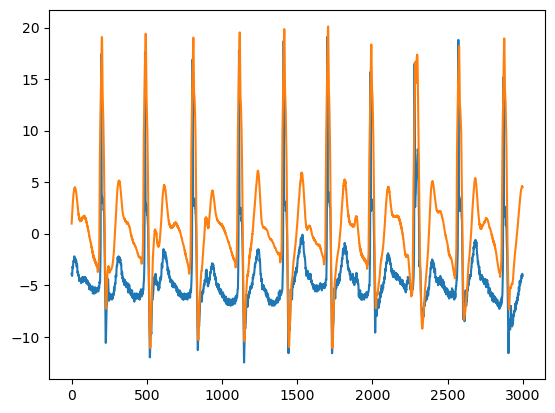

In [23]:
#read signal
database = "mit-bih-data"
record_num = "102"
sig = wfdb.rdsamp(database+ "/" + record_num)
x_both = sig[0][:].flatten()
x = x_both[0::2]

#read sampling frequency
fs = wfdb.rdsamp(database + "/"+ record_num)[1]['fs']
#read annotation file
record_name = database+ "/" + record_num
annotation = wfdb.rdann(record_name, 'atr')
beat_peaks = annotation.sample[:]
#get rid of baseline
butter_filter = signal.butter(5, 2, 'high', fs=fs, output='sos')
x_no_baseline = signal.sosfilt(butter_filter, x)
x_no_baseline[::-1] = signal.sosfilt(butter_filter, x_no_baseline[::-1])

#delay
delay = 1
x_no_baseline[:-delay] = x_no_baseline[delay:]

#apply haar filter
y = haar_filter(x_no_baseline,fs)

start_int =500
end_int = start_int + 3000
plt.plot(x[start_int:end_int]*20)
plt.plot(y[start_int:end_int])


In [20]:
candidates,s = get_candidates(y,x_no_baseline,fs)


In [21]:
detected = detect_beats(s,x_no_baseline,candidates, fs, T=0.1, beta2=0.05, beta1=0.21)


In [22]:
#tolerance for beat detection, 15ms
time_tolerance = 0.015
tolerance = round(time_tolerance*fs)

not_detected = []
for i in beat_peaks:
    for j in range(i-tolerance, i+tolerance+1):
        if j in detected :
            break
    if j == i+tolerance:
        not_detected.append(i)
        #print(i)


falsely_detected = []
for i in detected:
    for j in range(i-tolerance, i+tolerance+1):
        if j in beat_peaks:
            break
    if j == i+tolerance:
        falsely_detected.append(i)


print('Not detected:', len(not_detected))
print('Falsely detected:', len(falsely_detected))

SE = (len(detected) - len(falsely_detected))/len(beat_peaks)
PP = (len(detected) - len(falsely_detected))/len(detected) 
print('Sensitivity:', SE)
print('Positive predictivity:', PP)
print(not_detected)
print(falsely_detected)


Not detected: 56
Falsely detected: 54
Sensitivity: 0.9730839416058394
Positive predictivity: 0.9753086419753086
[68, 136, 11152, 27245, 28701, 29133, 34216, 38682, 62969, 72668, 99473, 119416, 123586, 137886, 146831, 157257, 188206, 206981, 207743, 239942, 250672, 254246, 275075, 281326, 287590, 296808, 335244, 341503, 354044, 356125, 371886, 381411, 407930, 414789, 416569, 434428, 443355, 449905, 450830, 455873, 457973, 473434, 475811, 496077, 505325, 511782, 528456, 536774, 542440, 544544, 570607, 584655, 603094, 620368, 624237, 645411]
[114, 11130, 27209, 28695, 37922, 38235, 72645, 99450, 119392, 123564, 137863, 146809, 157234, 188184, 206959, 207755, 239920, 250650, 254223, 275053, 281306, 287567, 296787, 335222, 341482, 354012, 356093, 371853, 381388, 407908, 414758, 416547, 434406, 443322, 449884, 450794, 455852, 457941, 473413, 475789, 496052, 505290, 511761, 528425, 536753, 542420, 544513, 570627, 584621, 603074, 610523, 620346, 624231, 645378]


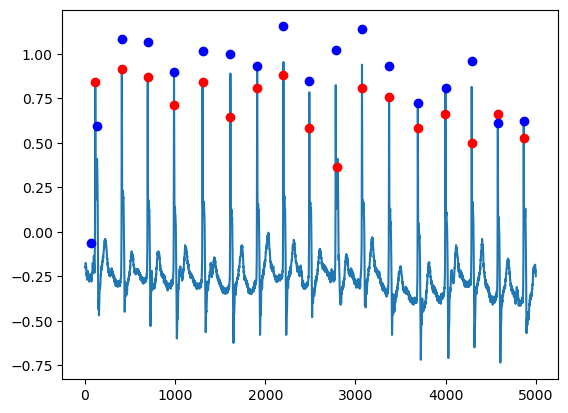

In [13]:
start_int =0
end_int = start_int + 5000
plt.plot(range(start_int, end_int), x[start_int:end_int])
detected_interval = [n for n in detected if n > start_int and n < end_int]
plt.plot(detected_interval, [x[n] for n in detected_interval], 'ro')
beat_peaks_interval = [n for n in beat_peaks if n > start_int and n < end_int]
plt.plot(beat_peaks_interval, [x[n] + 0.2 for n in beat_peaks_interval], 'bo')

In [ ]:
for i in range(24):
    #read signal
    record_num = str(100 + i)	
    sig = wfdb.rdsamp("mit-bih-data/" + record_num)
    x_both = sig[0][:].flatten()
    x = x_both[0::2]
    #read sampling frequency
    fs = wfdb.rdsamp("mit-bih-data/" + record_num)[1]['fs']
    #read annotation file
    record_name = 'mit-bih-data/' + record_num
    annotation = wfdb.rdann(record_name, 'atr')
    beat_peaks = annotation.sample[:]
    #get rid of baseline
    butter_filter = signal.butter(3, 0.6, 'high', fs=fs, output='sos')
    x_no_baseline = signal.sosfilt(butter_filter, x)
    #apply haar filter
    y = haar_filter(x_no_baseline,fs)
    candidates,s = get_candidates(y,x_no_baseline,fs)
    detected = detect_beats(s,x_no_baseline,candidates, fs, T=5, beta2=0.01, beta1=0.2)

    #tolerance for beat detection of 5 samples
    time_tolerance = 0.15
    tolerance = int(time_tolerance*fs)

    not_detected = []
    for i in beat_peaks:
        for j in range(i-tolerance, i+tolerance+1):
            if j in detected:
                break
        if j == i+tolerance:
            not_detected.append(i)
            #print(i)

    falsely_detected = []
    for i in detected:
        for j in range(i-tolerance, i+tolerance+1):
            if j in beat_peaks:
                break
        if j == i+tolerance:
            falsely_detected.append(i)

    print('Not detected:', len(not_detected))
    print('Falsely detected:', len(falsely_detected))

    SE = (len(detected) - len(falsely_detected))/len(beat_peaks)
    PP = (len(detected) - len(falsely_detected))/len(detected) 
    print('Sensitivity:', SE)
    print('Positive predictivity:', PP)

    

Not detected: 5
Falsely detected: 0
Sensitivity: 0.9978012313104662
Positive predictivity: 1.0
Not detected: 20
Falsely detected: 5
Sensitivity: 0.9893276414087513
Positive predictivity: 0.9973103819257665
Not detected: 70
Falsely detected: 64
Sensitivity: 0.9671532846715328
Positive predictivity: 0.9706959706959707
Not detected: 10
Falsely detected: 1
Sensitivity: 0.9952175992348159
Positive predictivity: 0.9995196926032661
Not detected: 285
Falsely detected: 218
Sensitivity: 0.8697533535266119
Positive predictivity: 0.9021543985637342
Not detected: 302
Falsely detected: 143
Sensitivity: 0.887402452619844
Positive predictivity: 0.9435005926511261
Not detected: 361
Falsely detected: 523
Sensitivity: 0.8274547187797903
Positive predictivity: 0.768481629039398
Not detected: 56
Falsely detected: 1786
Sensitivity: 0.927570093457944
Positive predictivity: 0.526385574118271
Not detected: 490
Falsely detected: 549
Sensitivity: 0.6858552631578947
Positive predictivity: 0.695
Not detected: 100


FileNotFoundError: [Errno 2] No such file or directory: 'c:\\Users\\marko\\Desktop\\biomedical_signal_processing\\OBSS-assignment1\\mit-bih-data\\110.hea'